# Модуль 25. A/B-тестирование: подготовка и проведение

## Мини-проект

**ПОСТАНОВКА ЗАДАЧИ**

К вам попали результаты A/A/B-тестирования от одного известного маркетплейса.

* *sample_a*, *sample_c* — АА-группы;
* *sample_b* — отдельная группа.

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

* *ctr* (отношение кликов к просмотрам товаров);
* *purchase rate* (отношение покупок к просмотрам товаров);
* *gmv* (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

Данные уже почищены по сессиям, вы можете использовать их в агрегированном виде. Ваша задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

Тест Шапиро-Уилка проведите на *alpha* = 0,01.

**Исходные данные:** Датасеты:
1. *sample_a.csv*;
2. *sample_b.csv*;
3. *sample_c.csv*;
4. *item_prices.csv*.

**1. Загрузка, анализ и предобработка данных. Расчет метрик**

In [1]:
# Импорт требуемых модулей и библиотек
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import math
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

**1.1. Анализ и обработка датасета *item_prices***

Начнем рассмотрение датасетов с последнего, т.к. из перевода его названия - "Цены товаров" - получается, что он должен содержать справочник цен товаров с которыми работает маркетплейс.

In [2]:
data = pd.read_csv("item_prices.csv")
data.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   item_id     1000 non-null   int64
 1   item_price  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


Как и предполагалось из названия, это датасет-справочник, в котором два признака:

* *item_id* - идентификатор товара;
* *item_price* - цена товара.

Проверим этот датасет на наличие полных дубликатов:

In [4]:
data.drop_duplicates(inplace=True)
data.shape[0]

1000

Видно, что количество строк в датасете после удаления дубликатов не изменилось, значит полных дубликатов в данных нет. Но, т.к. один и тот же товар в разное время может иметь разную цену, то нам для дальнейшей привязки этого справочника к другим датасетам, необходимо обеспечить уникальность записей в этом датасете по каждому товару. Проверим, обеспечивается ли это утверждение в предложенном датасете.

In [5]:
price = set(data['item_id'])
len(price)

955

Результаты получения количества уникальных значений идентификатора товаров показали, что количество строк в датасете больше, чем это количество. Это говорит о том, что в предложенном датасете есть одинаковые товары с несколькими разными ценами. Рассмотрим эти значения.

In [6]:
vc = data['item_id'].value_counts()
vc[vc.values > 1]

338     3
8581    3
5258    2
7204    2
8111    2
2945    2
6328    2
2761    2
4796    2
2675    2
533     2
3890    2
3006    2
5121    2
7963    2
7580    2
8604    2
3521    2
3387    2
1915    2
3375    2
1555    2
8871    2
8669    2
4220    2
4104    2
4359    2
7688    2
8589    2
8010    2
4440    2
9068    2
5556    2
8165    2
1173    2
5891    2
2622    2
5941    2
5037    2
8382    2
1883    2
8679    2
1462    2
Name: item_id, dtype: int64

Из полученного результата видно, что в данных есть товары, у которых присутствует 2 и 3 цены. Посмотрим некоторые из них:

In [7]:
data[data['item_id'] == 338]

,item_id,item_price
0,338,1501
797,338,1151
977,338,1047


In [8]:
data[data['item_id'] == 3521]

,item_id,item_price
65,3521,563
281,3521,1829


Как и предполагалось, у одного и того же товара есть несколько различных цен. Причем эти цены могут значительно различаться. Для обеспечения требования уникальности ключевых значений (*item_id*) в справочнике цен товаров будем использовать для полученных товаров усредненную цену. 

In [9]:
data = data.groupby(by='item_id').mean()
data

,item_price
item_id,
21,452.0
36,282.0
39,1746.0
50,871.0
64,1479.0
...,...
9936,379.0
9944,810.0
9958,265.0


Видно, что количество строк в датасете-справочнике уменьшилось, до количества уникальных идентификаторов товаров и *item_id* стало индексом датасета. Наш справочник готов к подключению к другим датасетам.

**1.2. Анализ и обработка датасета *simple_a***

Как следует из постановки задачи, данный датасет предлагает нам выборку данных по *А-группе*. Рассмотрим структуру и данные этого датасета.

In [10]:
data_a = pd.read_csv("sample_a.csv")
data_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [11]:
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


Из полученных данных видно, что *А-группа* представляет собой датасет со следующими признаками:

* *user_id* - идентификатор пользователя;
* *item_id* - идентификатор товара;
* *action_id* - идентификатор действия (0 — клик, 1 — просмотр и 2 — покупка).

В датасете нет не заполненных значений. Проверим наличие полных дубликатов в строках:

In [12]:
data_a.drop_duplicates(inplace=True)
data_a.shape[0]

1188912

Видно, что количество строк в датасете не изменилось - дубликатов нет.

Для удобства дальнейшего расчета метрик и выполнения других операций по данному датасету, произведем преобразование значения признака *action_id* в отдельные бинарные признаки для каждого типа действий.

In [13]:
data_a['viewing'] = data_a['action_id'].apply(lambda x: 1 if x==1 else 0)
data_a['click'] = data_a['action_id'].apply(lambda x: 1 if x==0 else 0)
data_a['purchase'] = data_a['action_id'].apply(lambda x: 1 if x==2 else 0)
# Удалим исходный признак action_id за ненадобностью
data_a.drop(columns='action_id', axis=1, inplace=True)
data_a

,user_id,item_id,viewing,click,purchase
0,84636,360,1,0,0
1,21217,9635,1,0,0
2,13445,8590,1,0,0
3,38450,5585,1,0,0
4,14160,2383,0,1,0
...,...,...,...,...,...
1188907,22999,2401,1,0,0
1188908,23700,4654,0,1,0
1188909,18842,3707,1,0,0
1188910,32732,9198,1,0,0


После проведения обработки мы получили обновленный датасет, в котором выполненные пользователем действия выведены как бинарные флаги в одноименных признаках.

Т.к. для расчета одной из требуемых по заданию метрик (*gmv*) нам потребуется сумма по купленному товару, то воспользуемся справочником цен товаров, полученным в п. 1.1 и присоединим его к рассматриваемому датасету через ключ *item_id*:

In [14]:
data_a = data_a.join(data, on='item_id', how='left')
data_a

,user_id,item_id,viewing,click,purchase,item_price
0,84636,360,1,0,0,1896.0
1,21217,9635,1,0,0,1699.0
2,13445,8590,1,0,0,846.0
3,38450,5585,1,0,0,1556.0
4,14160,2383,0,1,0,1956.0
...,...,...,...,...,...,...
1188907,22999,2401,1,0,0,1670.0
1188908,23700,4654,0,1,0,1080.0
1188909,18842,3707,1,0,0,656.0
1188910,32732,9198,1,0,0,1307.0


Т.к. при расчете метрики *gmv* нужна сумма покупки, а не цена товара, то произведем расчет суммы, как произведения признака *purchase* и *item_price* для каждой строки датасета.

In [15]:
data_a['item_sum'] = data_a['purchase'] * data_a['item_price']
# После вычисления суммы, цена товаров - не нужна
data_a.drop(columns='item_price', axis=1, inplace=True)
data_a

,user_id,item_id,viewing,click,purchase,item_sum
0,84636,360,1,0,0,0.0
1,21217,9635,1,0,0,0.0
2,13445,8590,1,0,0,0.0
3,38450,5585,1,0,0,0.0
4,14160,2383,0,1,0,0.0
...,...,...,...,...,...,...
1188907,22999,2401,1,0,0,0.0
1188908,23700,4654,0,1,0,0.0
1188909,18842,3707,1,0,0,0.0
1188910,32732,9198,1,0,0,0.0


Для получения итоговых данных в разрезе отдельного клиента и товара, свернем полученные данные по признакам *user_id* и *item_id*, просуммировав оставшиеся признаки:

In [16]:
data_a = data_a.groupby(by=['user_id','item_id']).sum()
data_a

viewing  click  purchase  item_sum
user_id item_id                                    
241     21             1      0         0       0.0
        36             1      0         0       0.0
        39             1      0         0       0.0
        50             1      0         0       0.0
        64             1      0         0       0.0
...                  ...    ...       ...       ...
99880   9936           1      0         0       0.0
        9944           1      0         0       0.0
        9958           1      0         0       0.0
        9989           1      0         0       0.0
        9994           1      0         0       0.0

[951130 rows x 4 columns]

Количество строк уменьшилось. Теперь можно произвести проверку наличия предварительных просмотров товаров перед каждой операцией клика на товаре или покупки товара. Для этого проанализируем частоту появления различных значений признака *viewing*.

In [17]:
data_a['viewing'].value_counts()

1    951130
Name: viewing, dtype: int64

Видно, что значение признака *viewing* имеет единственное значение - 1 и количество этих значений совпадает с количеством строк в свернутом датасете. Из этого можно заключить, что у нас нет ситуаций, когда клик или покупка происходят без действия предварительного просмотра.

Перед дальнейшим использованием полученного датасета, проведем визуальный анализ распределений исследуемых признаков.

array([[<Axes: title={'center': 'viewing'}>,
        <Axes: title={'center': 'click'}>],
       [<Axes: title={'center': 'purchase'}>,
        <Axes: title={'center': 'item_sum'}>]], dtype=object)

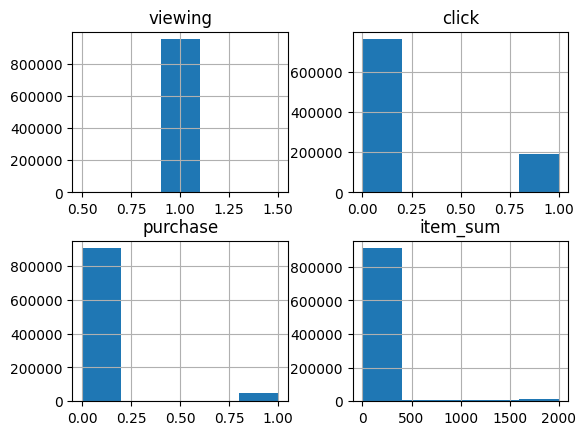

In [18]:
data_a.hist(bins=5)

Из полученных результатов можно сделать следующие предварительные выводы по датасету *А-группы*.

1. Как и было описано выше, каждой строке датасета соответствует предварительный просмотр товаров. Признак *viewing* имеет единственное значение равное *1* и частота его появления соответствует количеству записей в выборке.
2. Значение признака *click* имеет два значения - "1" и "0" (категориальный признак) и распределено не равномерно. Количество выполненных кликов составляет примерно 1/5 всей выборки.
3. Значение признака *purchase* также имеет два значения - "1" и "0" (категориальный признак) и также распределено не равномерно. Количество выполнных покупок имеет достаточно небольшое количество по отношению к общему количеству выборки.
4. *item_sum* является количественным денежным признаком с значениями в диапазоне от 0 до 2000 и распределяется не по нормальному закону. Основная масса покупок имеет сумму близкую к нулевому значению.

**Произведем расчет метрик**, определенных в задании к проекту для *А-группы*. Данные по метрикам для различных групп будем собирать в итоговый датафрейм для сравнения.

In [19]:
# ctr - А-группа
ctr = data_a['click'].sum()/data_a['viewing'].sum()

In [20]:
# purchase rate - А-группа
purchase_rate = data_a['purchase'].sum()/data_a['viewing'].sum()

In [21]:
# gmv - А-группа
gvm = data_a['item_sum'].sum()

In [22]:
row = {'sample':['A'],'size':[len(data_a)],'ctr':[ctr], 'purchase rate':[purchase_rate], 'gmv':[gvm]}
df_result = pd.DataFrame.from_dict(row)
df_result

,sample,size,ctr,purchase rate,gmv
0,A,951130,0.2,0.049999,5.087209e+07


Полученные данные по выборке *А-группы* будут базовыми для сравнения с данными в других рассмотренных группах.

**1.3. Анализ и обработка датасета *simple_b***

Обработаем датасет *simple_b* аналогично рассмотренному выше датасету *simple_a*.

In [23]:
data_b = pd.read_csv("sample_b.csv")
data_b.head()

,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1


In [24]:
data_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


Видно, что структура данных у данного датасета точно такая же, что и у предыдущего.

In [25]:
data_b.drop_duplicates(inplace=True)
data_b.shape[0]

1198438

Полных дубликатов данных - нет.

In [26]:
# Преобразуем типы действий в отдельные признаки
data_b['viewing'] = data_b['action_id'].apply(lambda x: 1 if x==1 else 0)
data_b['click'] = data_b['action_id'].apply(lambda x: 1 if x==0 else 0)
data_b['purchase'] = data_b['action_id'].apply(lambda x: 1 if x==2 else 0)
# Удалим старый признак с дествиями пользоватеелй
data_b.drop(columns='action_id', axis=1, inplace=True)
# Соединим данные датасета с данными справочника цен товаров
data_b = data_b.join(data, on='item_id', how='left')
# Расстичтаем итоговые суммы покупок
data_b['item_sum'] = data_b['purchase'] * data_b['item_price']
# Признак цены удаляем, т.к. далее будут использоваться суммы по товарам
data_b.drop(columns='item_price', axis=1, inplace=True)
# Свернем данные по пользователю и товару, суммируя остальные признаки
data_b = data_b.groupby(by=['user_id','item_id']).sum()
data_b

viewing  click  purchase  item_sum
user_id item_id                                    
100038  21             1      0         0       0.0
        36             1      0         0       0.0
        39             1      0         0       0.0
        50             1      0         0       0.0
        64             1      0         0       0.0
...                  ...    ...       ...       ...
199966  9936           1      1         0       0.0
        9944           1      0         0       0.0
        9958           1      1         1     265.0
        9989           1      0         0       0.0
        9994           1      0         0       0.0

[951141 rows x 4 columns]

Как и прошлый раз, количество строк уменьшилось. Проводим проверку наличия предварительных просмотров товаров перед каждой зафиксированной операцией:

In [27]:
data_b['viewing'].value_counts()

1    951141
Name: viewing, dtype: int64

Число строк датасета совпало с количеством значений просмотров, т.е. все операции имеют перед собой операцию просмотра.

Проведем визуальный анализ распределений исследуемых признаков в этом датасете.

array([[<Axes: title={'center': 'viewing'}>,
        <Axes: title={'center': 'click'}>],
       [<Axes: title={'center': 'purchase'}>,
        <Axes: title={'center': 'item_sum'}>]], dtype=object)

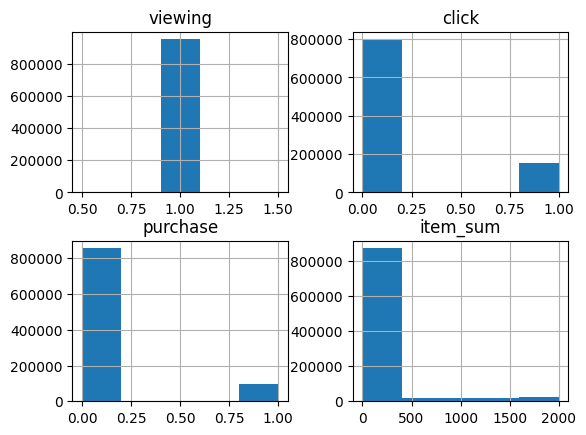

In [28]:
data_b.hist(bins=5)

Выводы, сделанные для датасета *simple_a* вполне применимы и для данного датасета, но также можно сделать ряд дополнительных выводов, основанных на сравнении соответствующих графиков обоих датасетов.

1. Размеры выборок групп *А* и *В* примерно одинаковы.
2. В признаке *click* наблюдается уменьшение количества значений равных *1*, что говорит о том, что пользователи в *В-группе* начали меньше кликать по товару.
3. В признаке *purchase* произошло увеличение количества значений равных *1*, что говорит о большем количестве реальных продаж в данной выборке.
4. Так же, по признаку *item_sum* видно увеличение сумм продаж, причем, возможно, лучше стали продаваться более дорогие товары.

**Произведем расчет метрик**, по рассматриваемому датасету и отправим их в итоговый датафрейм для сравнения.

In [29]:
# ctr - В-группа
ctr = data_b['click'].sum()/data_b['viewing'].sum()

In [30]:
# purchase rate - B-группа
purchase_rate = data_b['purchase'].sum()/data_b['viewing'].sum()

In [31]:
# gmv - B-группа
gvm = data_b['item_sum'].sum()

In [32]:
row = pd.DataFrame({'sample':['B'], 'size':[len(data_b)], 'ctr':[ctr], 'purchase rate':[purchase_rate], 'gmv':[gvm]})
df_result = pd.concat([df_result, row], ignore_index=True)
df_result

,sample,size,ctr,purchase rate,gmv
0,A,951130,0.20,0.049999,5.087209e+07
1,B,951141,0.16,0.100000,1.016682e+08


Сравнительный анализ метрик дает те же выводы, что и рассмотренный ранее визуальный анализ:

1. *ctr* - упал на 20%, пользователи стали меньше кликать по товару;
2. *purchase rate* - вырос в 2 раза, не смотря на снижение кликов пользователей.
3. *gmv* - вырос в 2 раза, что связано с увеличением числа продаж и, возможно, продажей более дорогих товаров.

**1.4. Анализ и обработка датасета *simple_c***

Обработаем датасет *simple_c* аналогично рассмотренным выше датасетам *simple_a* и *simple_b*.

In [33]:
data_c = pd.read_csv("sample_c.csv")
data_c.head()

,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2


In [34]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


Структура данных у данного датасета аналогична двум предыдущим рассмотренным (*simple_a* и *simple_b*).

In [35]:
data_c.drop_duplicates(inplace=True)
data_c.shape[0]

1205510

После удаления дубликатов, количество строк не изменилось, что означает, что полных дубликатов строк в данных нет.

In [36]:
# Преобразуем типы действий в отдельные признаки
data_c['viewing'] = data_c['action_id'].apply(lambda x: 1 if x==1 else 0)
data_c['click'] = data_c['action_id'].apply(lambda x: 1 if x==0 else 0)
data_c['purchase'] = data_c['action_id'].apply(lambda x: 1 if x==2 else 0)
# Удалим старый признак с дествиями пользоватеелй
data_c.drop(columns='action_id', axis=1, inplace=True)
# Соединим данные датасета с данными справочника цен товаров
data_c = data_c.join(data, on='item_id', how='left')
# Расстичтаем итоговые суммы покупок
data_c['item_sum'] = data_c['purchase'] * data_c['item_price']
# Признак цены удаляем, т.к. далее будут использоваться суммы по товарам
data_c.drop(columns='item_price', axis=1, inplace=True)
# Свернем данные по пользователю и товару, суммируя остальные признаки
data_c = data_c.groupby(by=['user_id','item_id']).sum()
data_c

viewing  click  purchase  item_sum
user_id item_id                                    
200225  21             1      0         0       0.0
        36             1      0         0       0.0
        39             1      1         0       0.0
        50             1      0         0       0.0
        64             1      0         1    1479.0
...                  ...    ...       ...       ...
299828  9936           1      0         0       0.0
        9944           1      0         0       0.0
        9958           1      1         0       0.0
        9989           1      0         0       0.0
        9994           1      0         0       0.0

[949221 rows x 4 columns]

Количество строк уменьшилось, но осталось соизмеримым с размером выборок *А* и *В* групп. Проверим наличие предварительных просмотров товаров перед каждой зафиксированной операцией:

In [37]:
data_c['viewing'].value_counts()

1    949221
Name: viewing, dtype: int64

Значение равное *1* присутствует во всех строках датасета, т.е. условие наличия предварительного просмотра товаров выполняется.

Проведем визуальный анализ распределений исследуемых признаков в этом датасете.

array([[<Axes: title={'center': 'viewing'}>,
        <Axes: title={'center': 'click'}>],
       [<Axes: title={'center': 'purchase'}>,
        <Axes: title={'center': 'item_sum'}>]], dtype=object)

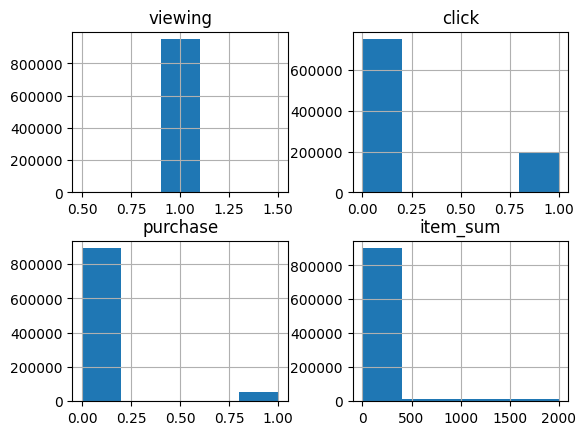

In [38]:
data_c.hist(bins=5)

Т.к. эта выборка (*С-группа*) сразу же была заявлена, как альтернативная *А-группа*, ее результаты по всем признакам визуально близки к графикам *А-группы*, рассмотренной в п.1.2. Выводы для *А-группы* также верны и для *С-группы*.

**Произведем расчет метрик**, по рассматриваемому датасету и отправим их в итоговый датафрейм для сравнения.

In [39]:
# ctr - C-группа
ctr = data_c['click'].sum()/data_c['viewing'].sum()

In [40]:
# purchase rate - C-группа
purchase_rate = data_c['purchase'].sum()/data_c['viewing'].sum()

In [41]:
# gmv - C-группа
gvm = data_c['item_sum'].sum()

In [42]:
row = pd.DataFrame({'sample':['C'], 'size':[len(data_c)], 'ctr':[ctr], 'purchase rate':[purchase_rate], 'gmv':[gvm]})
df_result = pd.concat([df_result, row], ignore_index=True)
df_result

,sample,size,ctr,purchase rate,gmv
0,A,951130,0.20,0.049999,5.087209e+07
1,B,951141,0.16,0.100000,1.016682e+08
2,C,949221,0.21,0.060000,6.087395e+07


Сравнивая результаты метрик *С-группы* с образцовой *А-группой* можно отметить следующее:

1. Размер выборки *С-группы* незначительно меньше, чем размер *А-группы*.
2. Как и в случае визуального анализа, подтверждается что по всем метрикам данная группа близка к *А-группе*.
3. В данной выборке все метрики немного больше, чем в *А-группе*.
4. При этом значения основных метрик в *С-группе* меньше значений метрик *В-группы*.

**2. Статистический анализ выборок по группам: А/А и А/В тесты**

В дополнение к рассчитанным метрикам, для формирования заключения об улучшении работы маркетплейса при использовании алгоритма, задействованного при работе с *В-группой*, необходимо использовать методы статистической проверки гипотез.

**2.1. Общие положения**

При выборе статистического критерия для тестирования гипотез необходимо опираться на характеристики данных, которые мы используем. Например, в источнике: [Проверка статистических гипотез](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html) предложена следующая классификация тестов:

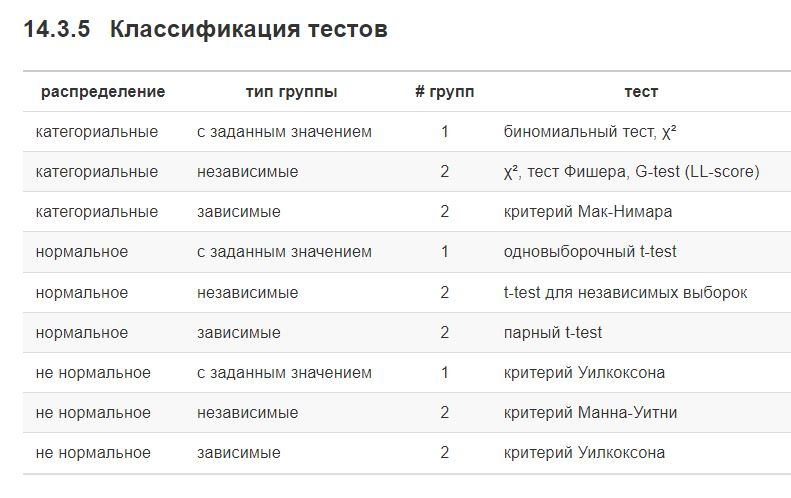

Исходя из этой классификации, можно сформулировать, какие параметры исследуемых данных нам следует определить.

1. *Распределение в группах*: частично известны из визуализации данных в пп. 1.2 - 1.4. Требует более детального анализа.
2. *Количество групп*: в нашем случае - это две группы.
3. *Типы групп*: необходимо определить.

Из предложенного списка у нас однозначно определено только **количество групп** - ***2 группы***. Остальные параметры требуют более детального рассмотрения.

**Оценка распределений в группах.** Для каждой из предложенных по заданию групп необходимо провести статистические тесты по всем признакам датасетов, на которых основываются значащие метрики: *click*, *purchase* и *item_sum*. При визуализации этих признаков в пп. 1.2 - 1.4 было определено следующее:
* Первые два признака (*click* и *purchase*) являются бинарными и представляют собой ***категориальные*** переменные с двумя значениями - "0" и "1".
* Признак *item_sum* является количественным признаком с конечными значениями в определенном диапазоне, которые распределяются не по нормальному закону.

Последнее утверждение требует проверки на нормальность распределения с использованием теста Шапиро-Уилка. Проведем этот тест для признака *item_sum* на всех трех сэмплах.

In [43]:
# Нулевая и альтернативная гипотезы
H0 = 'Распределения item_sum в группе нормальное'
H1 = 'Распределение item_sum в группе отлично от нормального'
alpha = 0.01 # уровень значимости (по заданию)

In [44]:
# Вычисляем результат теста Шапиро-Уилка для выборки А
shapiro_a = shapiro(data_a['item_sum'])
print('Результат теста Шапиро-Уилка для выборки А:')
print('p-value группы', round(shapiro_a.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if shapiro_a.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Результат теста Шапиро-Уилка для выборки А:
p-value группы 0.0
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: Распределение item_sum в группе отлично от нормального


In [45]:
# Вычисляем результат теста Шапиро-Уилка для выборки B
shapiro_b = shapiro(data_b['item_sum'])
print('Результат теста Шапиро-Уилка для выборки B:')
print('p-value группы', round(shapiro_a.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if shapiro_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Результат теста Шапиро-Уилка для выборки B:
p-value группы 0.0
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: Распределение item_sum в группе отлично от нормального


In [46]:
# Вычисляем результат теста Шапиро-Уилка для выборки C
shapiro_c = shapiro(data_c['item_sum'])
print('Результат теста Шапиро-Уилка для выборки C:')
print('p-value группы', round(shapiro_a.pvalue, 2))

# Сравниваем полученное p-value с уровнем значимости
if shapiro_c.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Результат теста Шапиро-Уилка для выборки C:
p-value группы 0.0
Отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу. H1: Распределение item_sum в группе отлично от нормального


Тест Шапиро-Уилка подтвердил наше изначальное предположение, что во всех предложенных сэммплах распределение признака *item_sum* ***отлично от нормального***.

**Оценка типов групп**. Из предложенных в классификации тестов типов групп сразу можно отбросить вариант "с заданным значением", т.к. в каждой группе отдельные записи  принадлежат разным пользователям. Но определение "зависимые" или "нет" эти группы, нам необходимо проверить. Убедимся, что в различных группах нет присутствия одних и тех же пользователей.

In [47]:
# Тест пересечения А/В-групп
group_a = set(data_a.index.get_level_values(0)) # user_id - A
group_b = set(data_b.index.get_level_values(0)) # user_id - B
user_intersection_ab = group_a.intersection(group_b)
len(user_intersection_ab)

0

Нулевое значение пересечения *А* и *В* групп, говорит о том, повторяющихся пользователей в указанных группах нет.

In [48]:
# Тест пересечения А/C-групп
group_a = set(data_a.index.get_level_values(0)) # user_id - A
group_c = set(data_c.index.get_level_values(0)) # user_id - C
user_intersection_ac = group_a.intersection(group_c)
len(user_intersection_ac)

0

Как и в прошлой подобной проверке, не обнаружено пользователей одновременно присутствующих как в *А*, так и в *С* группах.

In [49]:
# Тест пересечения B/C-групп
group_b = set(data_b.index.get_level_values(0)) # user_id - B
group_c = set(data_c.index.get_level_values(0)) # user_id - C
user_intersection_bc = group_b.intersection(group_c)
len(user_intersection_bc)

0

Опять пересечения по пользователям в датасетах не обнаружено. Т.е. все рассмотренные выборки можно считать ***независимыми***.

**Итого**, для проверки статистических гипотез в каждой паре датасетов нам потребуется два вида тестов:

* Тест для 2-х групп с категориальными независимыми признаками (*click* и *purchase*).
* Непараметрический тест для 2-х групп с независимыми признаками (*item_sum*).

**2.2. Тест равенства долей для A и C групп**

Для проверки гипотезы равенства пропорций бинарных признаков мы можем воспользоваться *z-критерием* для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии. Его мы будем применять для признаков *click* и *purchase*, соответствующим ключевым метрикам *ctr* и *purchase rate*.

Из задания к проекту и из рассчитанных метрик, мы знаем, что *С-группа* представляет собой альтернативную *А-группу*, которая предназначена для проведения А/А-теста. Данный вид теста позволяет максимально корректно оценить необходимый объём выборки для проведения А/В-теста.

Воспользуемся функциями из источника [A/B Testing with Binary Data: Two Sample Proportions z-test](https://towardsdatascience.com/a-b-testing-with-binary-data-two-sample-proportions-z-test-5c222d7772ad) для определения минимально необходимого размера выборки:

In [50]:
# Функция расчета Z-критерия
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

# Функция для определения минимально необходимого размера выборки
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:  # p_diff = p2-p1
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [51]:
alpha = 0.05 # уровень значимости

# Рассчитаем минимально необходимый размер выборки для А/С-теста по признаку 'ctr'
p1 = df_result['ctr'][0]
p_diff = df_result['ctr'][2] - df_result['ctr'][0]
print('Минимально необходимый размер выборки по признаку ctr:', sample_required(p1, p_diff, alpha))

Минимально необходимый размер выборки по признаку ctr: 8820


In [52]:
# Рассчитаем минимально необходимый размер выборки для А/С-теста по признаку 'purchase rate'
p1 = df_result['purchase rate'][0]
p_diff = df_result['purchase rate'][2]-df_result['purchase rate'][0]
print('Минимально необходимый размер выборки по признаку purchase rate:', sample_required(p1, p_diff, alpha))

Минимально необходимый размер выборки по признаку purchase rate: 2813


In [53]:
# Для вывода вспомним результаты метрик по выборкам
df_result

,sample,size,ctr,purchase rate,gmv
0,A,951130,0.20,0.049999,5.087209e+07
1,B,951141,0.16,0.100000,1.016682e+08
2,C,949221,0.21,0.060000,6.087395e+07


Из полученных результатов видно, что минимально необходимый размер выборки для категориальных признаков значительно меньше, чем доступные нам выборки *А/С-теста*. Это хорошо, т.к. обычно, чем больше у вас размер выборки, тем ближе результаты будут к результатам генеральной совокупности и соответственно точнее полученные результаты. Т.е. в дальнейшем будем использовать полные выборки по *А* и *С* группам.

Проведем z-тест для пропорций для каждого категориального признака используя библиотеку statsmodels.stats.proportion. Для этого и последующих тестов примем следующий уровень значимости:

In [54]:
alpha = 0.05

**2.2.1. Тест по метрике *ctr***

Подготовим данные по выборкам для удобства использования в тесте по метрике *ctr*.

In [55]:
row1 = {'group':'A', 'click':[data_a['click'].sum()], 'viewing':[data_a['viewing'].sum()], 'ctr':[df_result['ctr'][0]]}
df_ht = pd.DataFrame.from_dict(row1)
row2 = pd.DataFrame({'group':'C','click':[data_c['click'].sum()], 'viewing':[data_c['viewing'].sum()], 'ctr':[df_result['ctr'][2]]})
df_ht = pd.concat([df_ht, row2], ignore_index=True)
df_ht

,group,click,viewing,ctr
0,A,190226,951130,0.20
1,C,199336,949221,0.21


Сформулируем нулевую и альтернативные гипотезы для метрики *ctr* и проведем сам тест.

In [56]:
H0 = 'ctr в группах А и С равны'
H1 = 'ctr в группе А меньше, чем ctr в группе С'

In [57]:
# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=df_ht['click'], #число click'ов
    nobs=df_ht['viewing'], #общее число наблюдений
    alternative='smaller',
)
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  1.1774710555765216e-65
Отвергаем нулевую гипотезу. (ctr в группах А и С равны)
Альтернативная гипотеза. H1: ctr в группе А меньше, чем ctr в группе С


Подтвердили, что *ctr* в *А-группе* меньше чем в *С-группе* и эта разница имеет статистическую значимость.

**2.2.2. Тест по метрике *purchase rate***

Подготовим данные по выборкам для удобства использования в тесте по метрике *purchase rate*.

In [58]:
row1 = {'group':'A', 'purchase':[data_a['purchase'].sum()], 'viewing':[data_a['viewing'].sum()], 'purchase rate':[df_result['purchase rate'][0]]}
df_ht = pd.DataFrame.from_dict(row1)
row2 = pd.DataFrame({'group':'C','purchase':[data_c['purchase'].sum()], 'viewing':[data_c['viewing'].sum()], 'purchase rate':[df_result['purchase rate'][2]]})
df_ht = pd.concat([df_ht, row2], ignore_index=True)
df_ht

,group,purchase,viewing,purchase rate
0,A,47556,951130,0.049999
1,C,56953,949221,0.060000


Сформулируем нулевую и альтернативные гипотезы для метрики *purchase rate* и проведем тест.

In [59]:
H0 = 'purchase rate в группах А и С равны'
H1 = 'purchase rate в группе А меньше, чем purchase rate в группе С'

In [60]:
# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=df_ht['purchase'], #число покупок
    nobs=df_ht['viewing'], #общее число наблюдений
    alternative='smaller',
)
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  4.017576439527909e-201
Отвергаем нулевую гипотезу. (purchase rate в группах А и С равны)
Альтернативная гипотеза. H1: purchase rate в группе А меньше, чем purchase rate в группе С


Подтвердили, что *purchase rate* в *А-группе* меньше чем в *С-группе* и эта разница имеет статистическую значимость.

**2.2.3. Тест по метрике *gmv***

Как было выяснено ранее, для тестирования по метрике *gmv*, основанной на признаке *item_sum*, нам необходимо использование непараметрического теста для 2-х групп с независимыми признаками. По рекомендации классификации тестов приведенной в п.2.1, воспользуемся критерием Манна-Уитни или U-тестом.

Сформулируем нулевую и альтернативные гипотезы для метрики *gmv* и проведем тест.

In [61]:
H0 = 'gmv в группах А и С равны'
H1 = 'gmv в группе А меньше, чем gmv в группе С'

In [62]:
# Вычисляем значение p-value для U-теста
_, p = mannwhitneyu(data_a['item_sum'],
                    data_c['item_sum'],
                    alternative='less')
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  4.017576439527909e-201
Отвергаем нулевую гипотезу. (gmv в группах А и С равны)
Альтернативная гипотеза. H1: gmv в группе А меньше, чем gmv в группе С


Подтвердили, что *gmv* в *А-группе* меншьше чем в *С-группе* и эта разница имеет статистическую значимость.

**Выводы по А/С-тесту**. Проведенные статистические тесты равенства долей для *A* и *C* групп подтвердили результаты расчета численных значений метрик о том, что по всем показателям метрики *С-группы* лучше, чем в *А группе*. Несмотря на то, что и в *А* и в *С* группах не использовался улучшающий алгоритм, который проверялся на *В-группе*, увеличение значений параметров ключевых метрик в *С-группе* относительно не большое и может быть связанно с какими-либо неучтенными фактами по контингенту пользователей или их заинтересованностью в определенных товарах попавших в данную выборку. Возможно, необходимо произвести дополнительные исследования по данным направлениям. Необходим сбор дополнительных данных.

**2.3. Тест равенства долей для A и B групп**

Проведем те же тесты, что были использованы в предыдущем разделе для *А* и *С* групп. В данном случае в качестве второй группы будет выступать *В-группа*, на которую оказали воздействие, применив улучшающий алгоритм. Ранее, вычисленные метрики для *В-группы* показали прирост на значительно более высокие значения, чем в группе *С*. Проверим эти результаты на статистическую значимость с помощью статистических тестов равенства долей для *A* и *В* групп.

Вспомним результаты метрик по всем сэмплам:

In [63]:
df_result

,sample,size,ctr,purchase rate,gmv
0,A,951130,0.20,0.049999,5.087209e+07
1,B,951141,0.16,0.100000,1.016682e+08
2,C,949221,0.21,0.060000,6.087395e+07


Проверим выполнение условия минимально необходимого размера выборки для А/В-теста:

In [64]:
alpha = 0.05 # уровень значимости

# Рассчитаем минимально необходимый размер выборки для А/В-теста по признаку 'ctr'
p1 = df_result['ctr'][0]
p_diff = df_result['ctr'][0] - df_result['ctr'][1]
print('Минимально необходимый размер выборки по признаку ctr:', sample_required(p1, p_diff, alpha))

Минимально необходимый размер выборки по признаку ctr: 581


In [65]:
# Рассчитаем минимально необходимый размер выборки для А/В-теста по признаку 'purchase rate'
p1 = df_result['purchase rate'][0]
p_diff = df_result['purchase rate'][1]-df_result['purchase rate'][0]
print('Минимально необходимый размер выборки по признаку purchase rate:', sample_required(p1, p_diff, alpha))

Минимально необходимый размер выборки по признаку purchase rate: 151


По результатам видно, что минимально необходимый размер выборки для категориальных признаков значительно меньше, чем доступные нам выборки А/В-теста. Знаем, что чем больше у вас размер выборки, тем ближе результаты будут к результатам генеральной совокупности и соответственно точнее полученные результаты. Т.е. в дальнейшем будем использовать полные выборки по А и В группам.

Проведенм z-тест для пропорций для каждго категориального признака наших датасетов. Используемый уровень значимости:

In [66]:
alpha = 0.05

**2.3.1. Тест по метрике *ctr***

Подготовим данные по выборкам для удобства использования в тесте по метрике *ctr*.

In [67]:
row1 = {'group':'A', 'click':[data_a['click'].sum()], 'viewing':[data_a['viewing'].sum()], 'ctr':[df_result['ctr'][0]]}
df_ht = pd.DataFrame.from_dict(row1)
row2 = pd.DataFrame({'group':'B','click':[data_b['click'].sum()], 'viewing':[data_b['viewing'].sum()], 'ctr':[df_result['ctr'][1]]})
df_ht = pd.concat([df_ht, row2], ignore_index=True)
df_ht

,group,click,viewing,ctr
0,A,190226,951130,0.20
1,B,152183,951141,0.16


Сформулируем нулевую и альтернативные гипотезы для метрики ctr и проведем сам тест.

In [68]:
H0 = 'ctr в группах А и В равны'
H1 = 'ctr в группе А больше, чем ctr в группе В'

In [69]:
# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=df_ht['click'], #число click'ов
    nobs=df_ht['viewing'], #общее число наблюдений
    alternative='larger',
)
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. (ctr в группах А и В равны)
Альтернативная гипотеза. H1: ctr в группе А больше, чем ctr в группе В


Подтвердили, что *ctr* в *А-группе* больше чем в *В-группе* и эта разница имеет статистическую значимость.

**2.3.2. Тест по метрике *purchase rate***

Подготовим данные по выборкам для удобства использования в тесте по метрике *purchase rate*.

In [70]:
row1 = {'group':'A', 'purchase':[data_a['purchase'].sum()], 'viewing':[data_a['viewing'].sum()], 'purchase rate':[df_result['purchase rate'][0]]}
df_ht = pd.DataFrame.from_dict(row1)
row2 = pd.DataFrame({'group':'B','purchase':[data_b['purchase'].sum()], 'viewing':[data_b['viewing'].sum()], 'purchase rate':[df_result['purchase rate'][1]]})
df_ht = pd.concat([df_ht, row2], ignore_index=True)
df_ht

,group,purchase,viewing,purchase rate
0,A,47556,951130,0.049999
1,B,95114,951141,0.100000


Сформулируем нулевую и альтернативные гипотезы для метрики purchase rate и проведем тест.

In [71]:
H0 = 'purchase rate в группах А и B равны'
H1 = 'purchase rate в группе А меньше, чем purchase rate в группе B'

In [72]:
# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=df_ht['purchase'], #число покупок
    nobs=df_ht['viewing'], #общее число наблюдений
    alternative='smaller',
)
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. (purchase rate в группах А и B равны)
Альтернативная гипотеза. H1: purchase rate в группе А меньше, чем purchase rate в группе B


Подтвердили, что *purchase rate* в *А-группе* меньше чем в *B-группе* и эта разница имеет статистическую значимость.

**2.3.3. Тест по метрике *gmv***

Для метрики *gmv*, основанной на признаке *item_sum*, так же как и ранее воспользуемся критерием Манна-Уитни или U-тестом.

Сформулируем нулевую и альтернативные гипотезы для метрики *gmv* и проведем тест.

In [73]:
H0 = 'gmv в группах А и B равны'
H1 = 'gmv в группе А меньше, чем gmv в группе B'

In [74]:
# Вычисляем значение p-value для U-теста
_, p = mannwhitneyu(data_a['item_sum'],
                    data_b['item_sum'],
                    alternative='less')
print('p-value: ', p_value)

# Cравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. ({})".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу. (gmv в группах А и B равны)
Альтернативная гипотеза. H1: gmv в группе А меньше, чем gmv в группе B


Подтвердили, что *gmv* в *А-группе* меньше чем в *B-группе* и эта разница имеет статистическую значимость.

**Выводы по А/B-тесту.** Проведенные статистические тесты равенства долей для *A* и *B* групп подтвердили результаты расчета численных значений метрик о том, что по всем покупательным метрикам в *B-группе* значения выше, чем в *А* группе. Нам известно, что на *В-группе* проверялся улучшенный алгоритм, который должен был улучшить работу всего маркетплейса. Улучшение параметров ключевых метрик в *В-группе* подтверждается статистической значимостью проведенных тестов.

**3. Выводы по проекту** 

1. В результате анализа данных по *А/А(С)-тесту* выяснено, что условия проведения теста требуют дополнительных исследований и уточнений, т.к. обнаружена статистически значимая разница при сравнении результатов *А-группы* и *С-группы*, которые работали на одной и той же версии маркплейса без улучшений. Предположительно, необходимо изучить различия групп пользователей в этих выборках, какие товары они покупали, а также проверить другие факторы, которые могли повлиять на значимое различие в покупках этих групп.
2. В результате анализа данных по *А/В-тесту* можно сделать заключение, что использование нового алгоритма в работе маркетплейса привело к значительному увеличению продаж (в 2 раза), а это, в свою очередь, означает, что нововведение привело к улучшению работы маркетплейса в целом. Данное заключение можно сделать, не смотря на первый вывод (необходима доработка алгоритма проведения теста), т.к. произошло серьезное улучшение продажных метрик, значительно перекрывающее отклонения, возникшие из-за недоработок условия проведения тестов.
3. Так же, необходимо отметить, что при внедрении нового алгоритма в маркетплейсе конечные пользователи начали делать больше покупок (операция *purchase*) минуя операцию более детального просмотра информации по товару (операция *click*). Возможно, новый алгоритм улучшения связан с большей информационной насыщенностью по товару при просмотре товаров (операция *viewing*).